In [41]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [ ]:
# LpOH (2M), V70 (1:100),
# 8 mL total volume:

# Pump 1: LpOH + THF (+ TFEA for copoly.)
# Pump 2: V70 + THF

# 

In [183]:
def calculate_flow_rate_ramp_trajectory(
    t_max_min, 
    reactor_volume_mL=10, 
    initial_flow_rate_mL_per_min=0.01, 
    final_flow_rate_mL_per_min=1, 
    increment_time_min=0.5,
    ramp_shape=0.9):

    
    num_increments = int(t_max_min / increment_time_min) + 1
    time_steps = np.linspace(0, t_max_min, num=num_increments)
    
    
    if final_flow_rate_mL_per_min > initial_flow_rate_mL_per_min:
        ramp = (time_steps / t_max_min) ** (1/(1-ramp_shape))
    else:
        ramp = (time_steps / t_max_min) ** (1-ramp_shape)
    flow_rates = initial_flow_rate_mL_per_min + (final_flow_rate_mL_per_min - initial_flow_rate_mL_per_min) * ramp
    
    # Create a dataframe to capture each change in flow rate at exact time steps
    data = []
    previous_volume = 0
    for i in range(len(time_steps)):
        if i > 0:
            # Record the moment just before the flow rate changes
            delta_volume = flow_rates[i-1] * (time_steps[i] - time_steps[i-1])
            volume_dispensed = previous_volume + delta_volume
            data.append([time_steps[i], flow_rates[i-1], volume_dispensed, reactor_volume_mL, reactor_volume_mL/flow_rates[i-1]])
        # Calculate volume dispensed from the previous time to the current time
        if i > 0:
            volume_dispensed = previous_volume + flow_rates[i-1] * (time_steps[i] - time_steps[i-1])
        else:
            volume_dispensed = 0  # No volume dispensed at the start
        data.append([time_steps[i], flow_rates[i], volume_dispensed, reactor_volume_mL, reactor_volume_mL/flow_rates[i]])
        previous_volume = volume_dispensed

    # delta_volume = flow_rates[i] * (2*n - time_steps[i])
    # volume_dispensed = previous_volume + delta_volume
    # data.append([2*t_max_min, flow_rates[i], volume_dispensed, reactor_volume_mL, reactor_volume_mL/flow_rates[i]])
    # Convert list to DataFrame
    df = pd.DataFrame(data, columns=['time_min', 'flow_rate_mL_per_min', 'cum_volume_dispensed_mL', 'reactor_volume_mL', 'residence_time_min'])
    df['volume_dispensed_mL'] = np.diff(df['cum_volume_dispensed_mL'], prepend=0)
    # Drop duplicates keeping the first occurrence
    df = df.drop_duplicates(subset='cum_volume_dispensed_mL', keep='last')
    f = interp1d(df['cum_volume_dispensed_mL'], df['time_min'], kind='linear', fill_value="extrapolate")

    # Compute the target volumes and corresponding times
    target_volumes = df['cum_volume_dispensed_mL'] + reactor_volume_mL
    target_times = f(target_volumes)
    df['collection_time_min'] = target_times
    df['adjusted_residence_time_min'] = df['collection_time_min'] - df['time_min']
        
    return df

t_max_min = 10
df_flow = calculate_flow_rate_ramp_trajectory(
    t_max_min=t_max_min, 
    reactor_volume_mL=10,
    initial_flow_rate_mL_per_min=1.0, # 0.083
    final_flow_rate_mL_per_min=0.1, # 
    increment_time_min=10/60,
    ramp_shape=0.0
)

print('Total volume dispensed (mL):', df_flow['cum_volume_dispensed_mL'].iloc[-1])
print('Total reaction time (min):', max(df_flow['collection_time_min']))
print('Minimum flow rate (mL/min):', min(df_flow['flow_rate_mL_per_min']))
print('Maximum flow rate (mL/min):', max(df_flow['flow_rate_mL_per_min']))
print('Minimum residence time (min):', min(df_flow['adjusted_residence_time_min']))
print('Maximum residence time (min):', max(df_flow['adjusted_residence_time_min']))
df_flow

Total volume dispensed (mL): 5.575
Total reaction time (min): 96.95652173912954
Minimum flow rate (mL/min): 0.09999999999999998
Maximum flow rate (mL/min): 1.0
Minimum residence time (min): 48.47826086956482
Maximum residence time (min): 86.95652173912954


,time_min,flow_rate_mL_per_min,cum_volume_dispensed_mL,reactor_volume_mL,residence_time_min,volume_dispensed_mL,collection_time_min,adjusted_residence_time_min
0,0.000000,1.000,0.000000,10,10.000000,0.0,48.478261,48.478261
2,0.166667,0.985,0.166667,10,10.152284,0.0,49.927536,49.760870
4,0.333333,0.970,0.330833,10,10.309278,0.0,51.355072,51.021739
6,0.500000,0.955,0.492500,10,10.471204,0.0,52.760870,52.260870
8,0.666667,0.940,0.651667,10,10.638298,0.0,54.144928,53.478261
...,...,...,...,...,...,...,...,...
112,9.333333,0.160,5.483333,10,62.500000,0.0,96.159420,86.826087
114,9.500000,0.145,5.510000,10,68.965517,0.0,96.391304,86.891304
116,9.666667,0.130,5.534167,10,76.923077,0.0,96.601449,86.934783
118,9.833333,0.115,5.555833,10,86.956522,0.0,96.789855,86.956522


In [216]:
# 2 mL reactor volume
min_flowrate_mL_min = 0.01
max_flowrate_mL_min = 1.0

sm_reactor_vol_mL = 2
lg_reactor_vol_mL = 10

print(f'Small reactor ({sm_reactor_vol_mL} mL) residence time:')
print(f'\tmin: {sm_reactor_vol_mL / max_flowrate_mL_min:.2f} min')
print(f'\tmax: {sm_reactor_vol_mL / min_flowrate_mL_min:.2f} min')

print(f'Large reactor ({lg_reactor_vol_mL} mL) residence time:')
print(f'\tmin: {lg_reactor_vol_mL / max_flowrate_mL_min:.2f} min')
print(f'\tmax: {lg_reactor_vol_mL / min_flowrate_mL_min:.2f} min')

Small reactor (2 mL) residence time:
	min: 2.00 min
	max: 200.00 min
Large reactor (10 mL) residence time:
	min: 10.00 min
	max: 1000.00 min


In [ ]:
# Let's switch to 2mL
# Procedure:
# - Flow through the small reactor.
# - Max flowrate gives lowest residence time (2 min)
# Pump 2 mL through reactor, and observe when it is detected by NMR.
# - Once it is, note that time.
# - Immediately set the flow rate to minimum flow rate (or lesser flow rate)
# - Collect the data for that time + the dead volume time. 
# Once you set to that time, you can wait ten seconds, then push solvent?

# Requires essentially reactor volume + tubing volume 

# Start with solvent plug. Once sample is detected, we can immediately set the minimum flow rate.
# We can wait for a little while, perhaps, 10 min (12cm length), then flush with solvent.
# When all reactant is flushed and we only get solvent --> that's the dead time. 
# We use the dead time to go back to calculate the residence time.

In [220]:
tube_diameter_cm = 1.0 / 10 ## mm to cm
tube_area_cm2 = np.pi * (tube_diameter_cm / 2)**2

tube_volume_cm3 = 0.1

tube_length_cm = tube_volume_cm3 / tube_area_cm2 
print('Tube length (cm):', tube_length_cm)

Tube length (cm): 12.732395447351626


In [217]:
1 / 0.01

100.0

In [176]:
# How to sweep the largest range of residence times with the smallest volume dispensed?

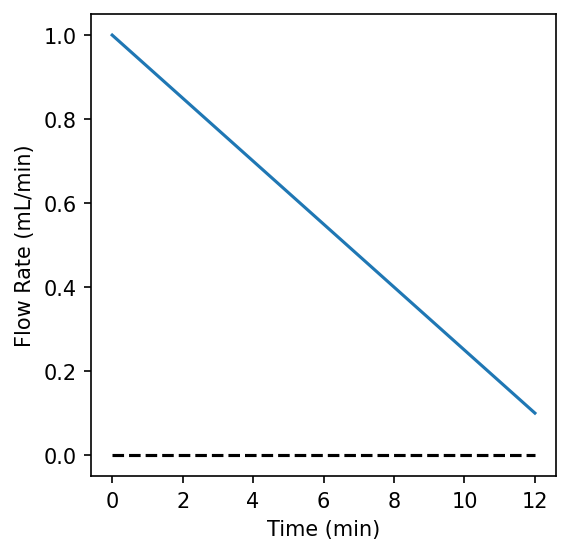

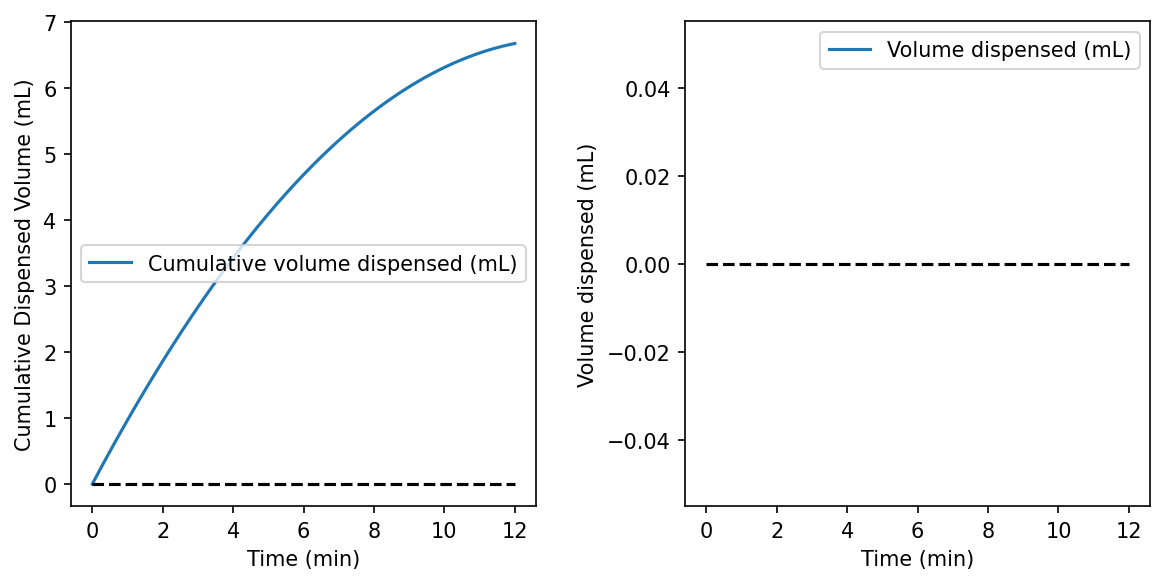

In [177]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.plot(df_flow['time_min'], df_flow['flow_rate_mL_per_min'], label='Flow rate (mL/min)')
ax.plot([0, t_max_min], [0, 0], 'k--')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Flow Rate (mL/min)')

fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
axs[0].plot(df_flow['time_min'], df_flow['cum_volume_dispensed_mL'], label='Cumulative volume dispensed (mL)')
axs[0].plot([0, t_max_min], [0, 0], 'k--')
axs[0].set_xlabel('Time (min)')
axs[0].set_ylabel('Cumulative Dispensed Volume (mL)')
axs[0].legend()

df_flow_plot = df_flow[df_flow['volume_dispensed_mL'] > 0]
axs[1].plot(df_flow_plot['time_min'], df_flow_plot['volume_dispensed_mL'], label='Volume dispensed (mL)')
axs[1].plot([0, t_max_min], [0, 0], 'k--')
axs[1].set_xlabel('Time (min)')
axs[1].set_ylabel('Volume dispensed (mL)')
axs[1].legend()
plt.tight_layout()

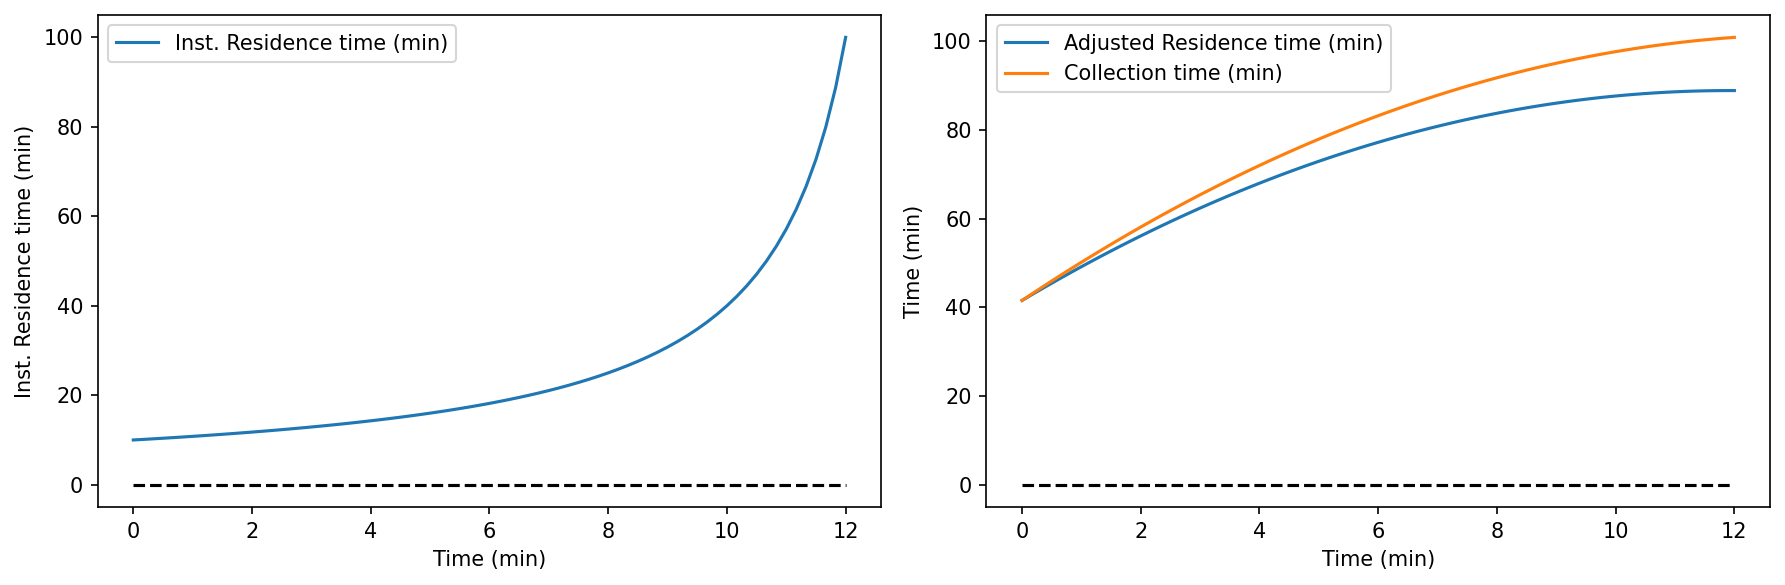

In [181]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=150)
axs[0].plot(df_flow['time_min'], df_flow['residence_time_min'], label='Inst. Residence time (min)')
axs[0].plot([0, t_max_min], [0, 0], 'k--')
axs[0].set_xlabel('Time (min)')
axs[0].set_ylabel('Inst. Residence time (min)')
axs[0].legend()

axs[1].plot(df_flow['time_min'], df_flow['adjusted_residence_time_min'], label='Adjusted Residence time (min)')
axs[1].plot(df_flow['time_min'], df_flow['collection_time_min'], label='Collection time (min)')
axs[1].plot([0, t_max_min], [0, 0], 'k--')
axs[1].set_xlabel('Time (min)')
axs[1].set_ylabel('Time (min)')
axs[1].legend()
plt.tight_layout()

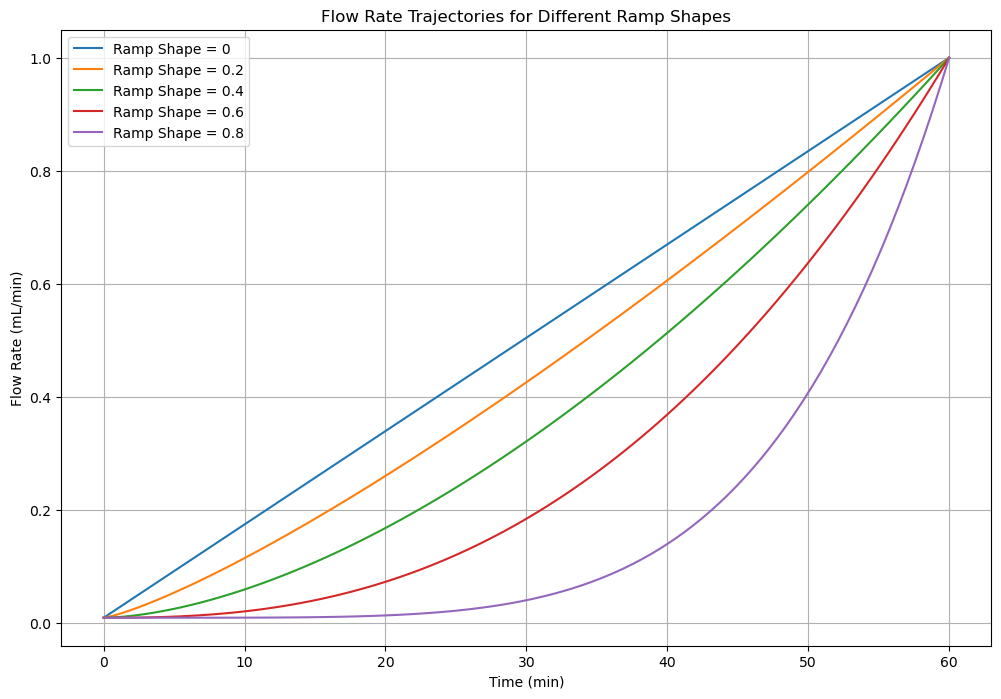

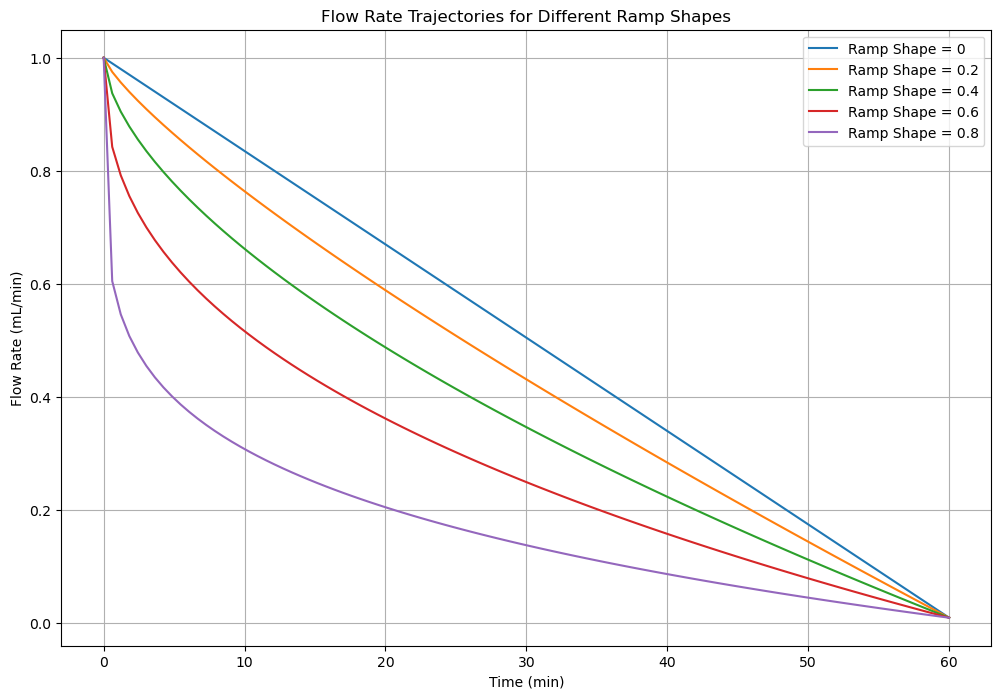

In [179]:
import numpy as np
import matplotlib.pyplot as plt

def plot_flow_rates(t_max_min, initial_flow_rate_mL_per_min, final_flow_rate_mL_per_min, ramp_shapes):
    time_steps = np.linspace(0, t_max_min, 100)  # 100 time points for smooth curves
    plt.figure(figsize=(12, 8))

    for ramp_shape in ramp_shapes:
        if initial_flow_rate_mL_per_min < final_flow_rate_mL_per_min: # Ramping up
            flow_rates = initial_flow_rate_mL_per_min + (final_flow_rate_mL_per_min - initial_flow_rate_mL_per_min) * (time_steps / t_max_min) ** (1 / (1 - ramp_shape))
        else: # Ramping down
            flow_rates = initial_flow_rate_mL_per_min + (final_flow_rate_mL_per_min - initial_flow_rate_mL_per_min) * ((time_steps / t_max_min) ** (1- ramp_shape))
        plt.plot(time_steps, flow_rates, label=f'Ramp Shape = {ramp_shape}')

    plt.title('Flow Rate Trajectories for Different Ramp Shapes')
    plt.xlabel('Time (min)')
    plt.ylabel('Flow Rate (mL/min)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters
t_max_min = 60  # Total time in minutes
initial_flow_rate_mL_per_min = 1  # Initial flow rate in mL/min
final_flow_rate_mL_per_min = 0.01  # Final flow rate in mL/min
ramp_shapes = [0, 0.2, 0.4, 0.6, 0.8]  # Different ramp shapes from linear to exponential

# Plotting
plot_flow_rates(t_max_min, 0.01, 1, ramp_shapes)
plot_flow_rates(t_max_min, 1, 0.01, ramp_shapes)